# Images of satellites classification

In [37]:
from google_images_download import google_images_download   #importing the library
import pandas
import cv2 #to load and displays images
import matplotlib.pyplot as plt
import imutils
import os
import pandas as pd
from shutil import copyfile

## Download images of satellites / non satellites

In [2]:
nb_images = 2000 # The number of images to download (both from satellite and non satellite images)
download = False  # Are we doanloading the images ?
chromeDriverPath = "/usr/bin/chromedriver"

In [3]:
def downloadImages(tags, nbImgs):
    response = google_images_download.googleimagesdownload()   #class instantiation

    arguments = {"keywords":','.join(tags),"limit":nbImgs,"print_urls":False, "extract_metadata":True, "thumbnail_only":True, "chromedriver":chromeDriverPath}   #creating list of arguments
    if download:
        response.download(arguments)   #passing the arguments to the function

download list of satellites categories

In [4]:
# categories taken from https://www.omicsonline.org/conferences-list/types-of-satellites-and-applications
categories = ["Communications Satellite","Remote Sensing Satellite","Navigation Satellite","LEO satellite", 
              "MEO satellite", "HEO satellite","GPS satellite","GEO satellite","Drone Satellite",
              "Polar Satellite","Nano Satellites","CubeSats","SmallSats"]

In [5]:
downloadImages(categories, nb_images)

In [6]:
catpd = [pandas.read_json("logs/" + str(cat) + ".json") for cat in categories]

### download of images

In [7]:
downloadImages(["satellite","images"], nb_images)

In [8]:
imgpd = pandas.read_json("logs/images.json")
satpd = pandas.read_json("logs/satellite.json")

In [9]:
imgpd.image_filename.count(), satpd.image_filename.count()

(397, 398)

In [10]:
satpd.iloc[0]

image_description      Virgin Orbit Tests its Satellite-Delivery Rock...
image_filename                          virgin-orbit-first-release-2.jpg
image_format                                                         jpg
image_height                                                         615
image_host                                             universetoday.com
image_link             https://www.universetoday.com/wp-content/uploa...
image_source           https://www.universetoday.com/142812/virgin-or...
image_thumbnail_url    https://encrypted-tbn0.gstatic.com/images?q=tb...
image_width                                                         1000
Name: 0, dtype: object

### display of the first images

In [11]:
def draw_imgs(imgs_list):
    l = int(len(imgs_list))
    n = int(len(imgs_list[0]))
    _, axs = plt.subplots(l, n, figsize=(17, 17))
    axs = axs.flatten()
    for img, ax in zip([item for sublist in imgs_list for item in sublist], axs):
        ax.imshow(img)
    plt.show()

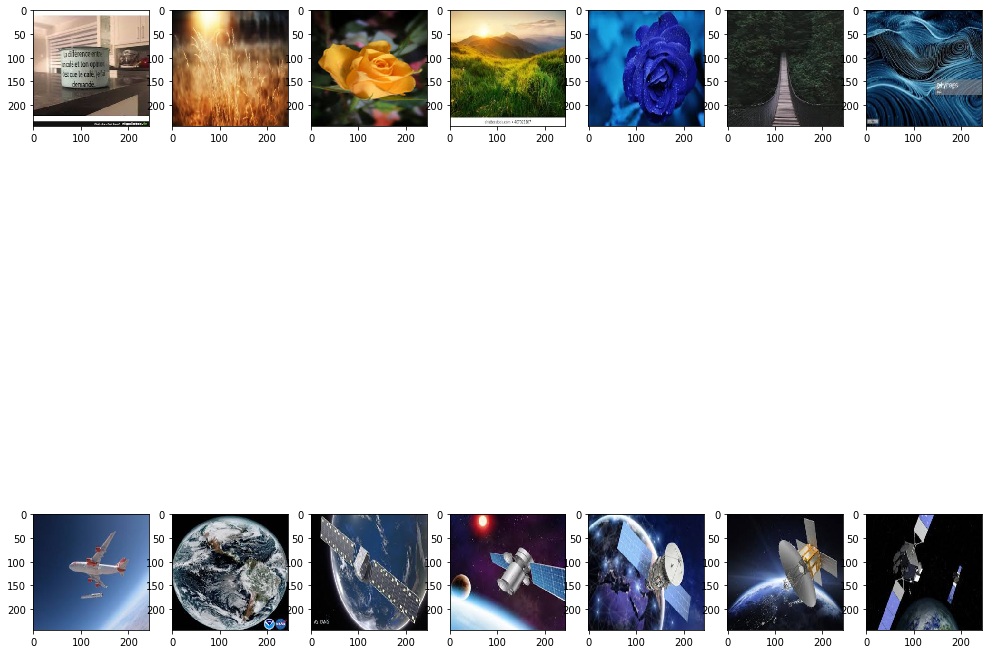

In [12]:
listnonsat = []
for i in range(0,7):
    img =cv2.imread("./downloads/images - thumbnail/"+imgpd.image_filename[i])
    img = cv2.resize(img, (244,244), cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    listnonsat.append(img)
    
listsat = []
for i in range(0,7):
    img =cv2.imread("./downloads/satellite - thumbnail/"+satpd.image_filename[i])
    img = cv2.resize(img, (244,244), cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    listsat.append(img)
    
draw_imgs([listnonsat, listsat])



Communications Satellite
Remote Sensing Satellite
Navigation Satellite
LEO satellite
MEO satellite
HEO satellite
GPS satellite
GEO satellite
Drone Satellite
Polar Satellite
Nano Satellites
CubeSats
SmallSats


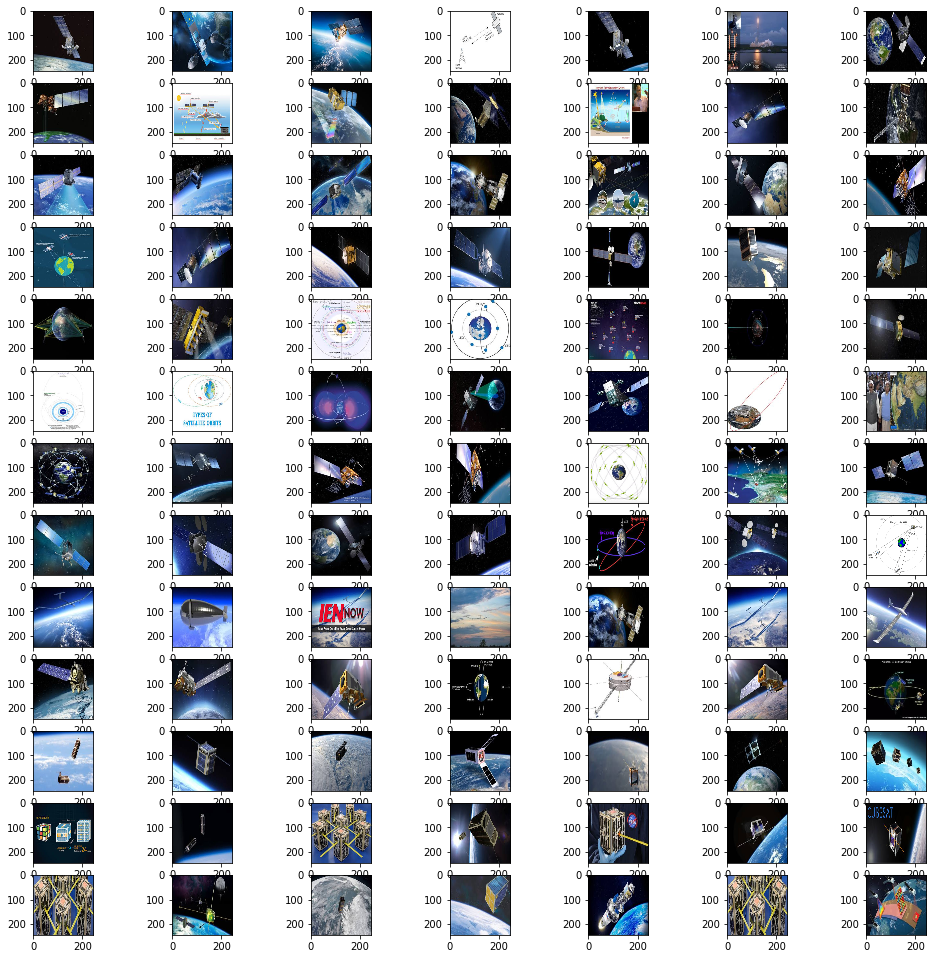

In [13]:
listcat = []
for current,cat in zip(catpd, categories):
    print(cat)
    listcurrent = []
    for i in range(0,7):
        img =cv2.imread("./downloads/"+str(cat)+" - thumbnail/"+current.image_filename[i])
        img = cv2.resize(img, (244,244), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        listcurrent.append(img)
    listcat.append(listcurrent)
    
draw_imgs(listcat)

## Classify satellite images

In [14]:
#saving images in the right directories for keras CNN

train_size = 200
test_size = 100

try:
    os.mkdir("./classification")
    os.mkdir("./classification/test")
    os.mkdir("./classification/test/images")
    os.mkdir("./classification/test/satellite")
    os.mkdir("./classification/train")
    os.mkdir("./classification/train/images")
    os.mkdir("./classification/train/satellite")
    os.mkdir("./classification/valid")
    os.mkdir("./classification/valid/images")
    os.mkdir("./classification/valid/satellite")
except:
    print("directories already in place")

def path_from_number(n):
    if i<=train_size:
        path="train"
    else:
        if i<=train_size+test_size:
            path = "test"
        else:
            path = "valid"
    return path

listnonsat = []
for i in range(0,imgpd.shape[0]):
    try:
        img =cv2.imread("./downloads/images - thumbnail/"+imgpd.image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite("./classification/" + path_from_number(i)+"/images/"+str(i)+".jpg", img)
        listnonsat.append(img)
    except:
        print("image not resizable")
    
listsat = []
for i in range(0,satpd.shape[0]):
    try:
        img =cv2.imread("./downloads/satellite - thumbnail/"+satpd.image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)         
        cv2.imwrite("./classification/" + path_from_number(i)+"/satellite/"+str(i)+".jpg", img)
        listsat.append(img)
    except:
        print("image not resizable")
    

directories already in place
image not resizable
image not resizable


In [15]:
len(listnonsat), len(listsat)

(396, 397)

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import time
IMG_SIZE = 64 # Replace with the size of your images
NB_CHANNELS = 3 # 3 for RGB images or 1 for grayscale images
BATCH_SIZE = 32 # Typical values are 8, 16 or 32
NB_TRAIN_IMG = 200 # Replace with the total number training images
NB_VALID_IMG = 50 # Replace with the total number validation images


/home/franck/data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [17]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, 
               kernel_size=(2,2), 
               strides=(1,1),
               padding='same',
               input_shape=(IMG_SIZE,IMG_SIZE,NB_CHANNELS),
               data_format='channels_last'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=64,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=128,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Flatten())        
cnn.add(Dense(32))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       32896     
__________

In [19]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'classification/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'classification/valid',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')


Found 400 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [20]:
cnn.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=80)

Epoch 1/20
100/100 [==============================] - 45s 451ms/step - loss: 0.4190 - acc: 0.8081 - val_loss: 0.9538 - val_acc: 0.6309
Epoch 2/20
100/100 [==============================] - 44s 438ms/step - loss: 0.3132 - acc: 0.8637 - val_loss: 0.4287 - val_acc: 0.8233
Epoch 3/20
100/100 [==============================] - 50s 503ms/step - loss: 0.2522 - acc: 0.9072 - val_loss: 0.4422 - val_acc: 0.8245
Epoch 4/20
100/100 [==============================] - 46s 457ms/step - loss: 0.1920 - acc: 0.9234 - val_loss: 0.6471 - val_acc: 0.7981
Epoch 5/20
100/100 [==============================] - 45s 447ms/step - loss: 0.1502 - acc: 0.9434 - val_loss: 0.4875 - val_acc: 0.8451
Epoch 6/20
100/100 [==============================] - 43s 432ms/step - loss: 0.1220 - acc: 0.9553 - val_loss: 0.5948 - val_acc: 0.8391
Epoch 7/20
100/100 [==============================] - 43s 425ms/step - loss: 0.0951 - acc: 0.9631 - val_loss: 0.6176 - val_acc: 0.8588
Epoch 8/20
100/100 [==============================] - 4

In [21]:
cnn.save_weights('cnn.h5')

In [22]:
cnn.load_weights('cnn.h5')

In [23]:
test_generator = test_datagen.flow_from_directory(
        'classification/test',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')
test_imgs, test_labels = next(test_generator)

Found 200 images belonging to 2 classes.


In [24]:
test_imgs.shape

(32, 64, 64, 3)

In [25]:
predictions = cnn.predict_generator(test_generator, steps=1)

In [26]:
predictions.shape

(32, 1)

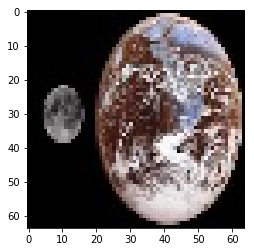

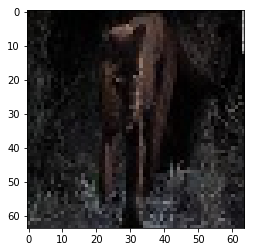

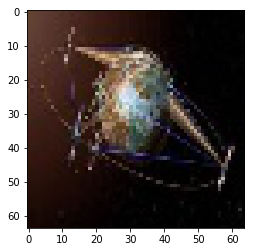

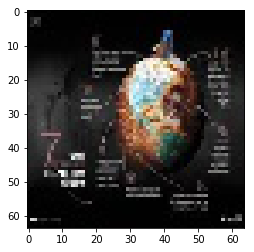

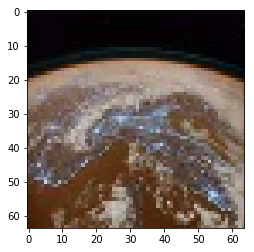

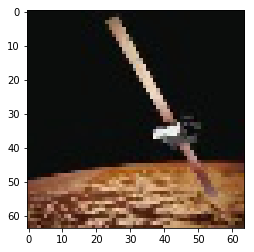

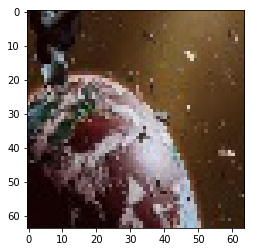

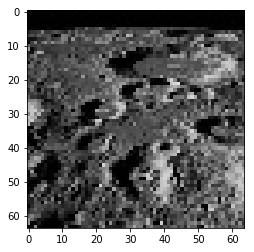

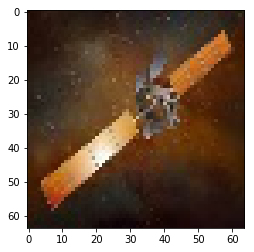

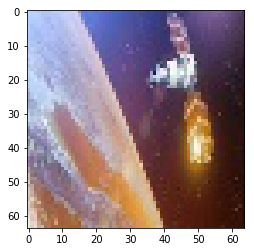

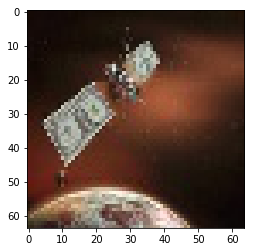

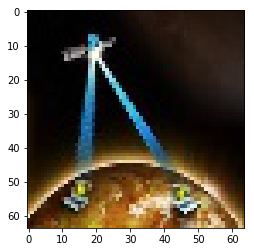

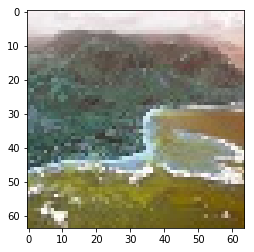

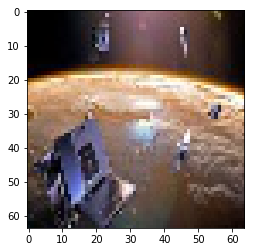

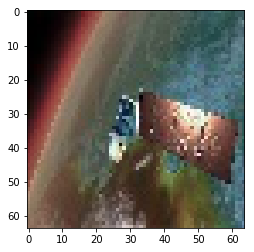

In [27]:
# check satellites
for i in range(0,predictions.shape[0]):
    if predictions[i]>0.5:
        plt.figure()
        plt.imshow(test_imgs[i])

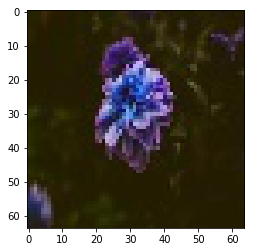

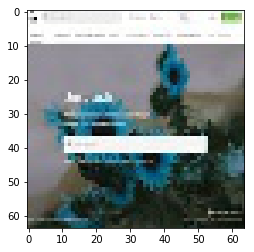

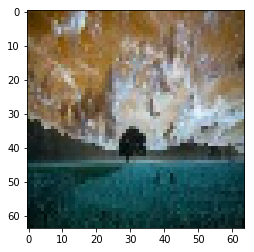

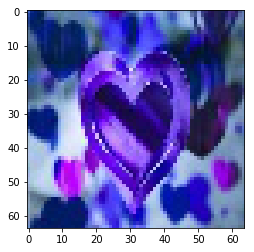

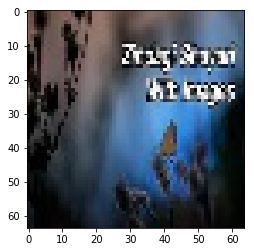

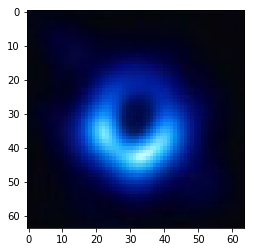

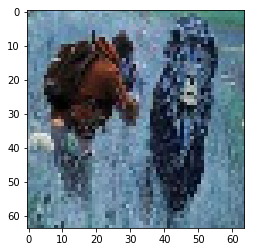

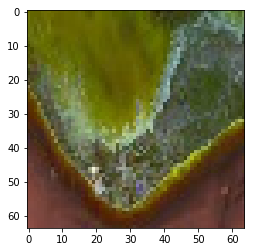

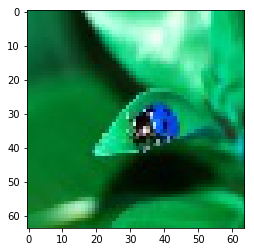

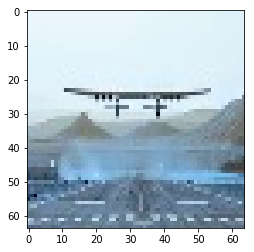

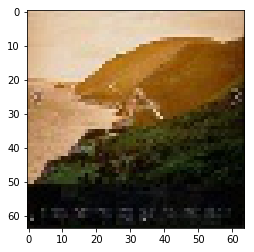

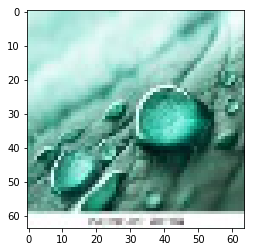

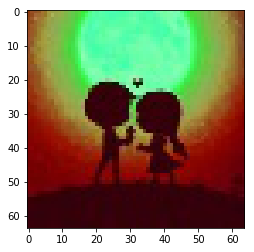

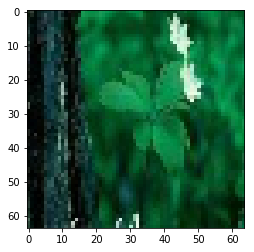

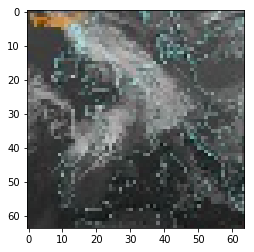

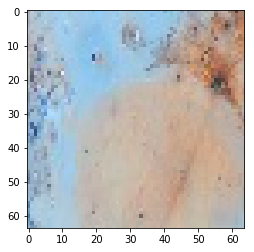

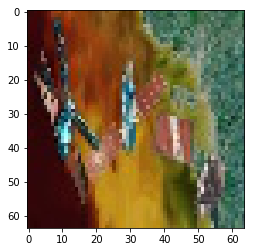

In [28]:
# check non satellites
for i in range(0,predictions.shape[0]):
    if predictions[i]<0.5:
        plt.figure()
        plt.imshow(test_imgs[i])

## filtering specific satellites datasets

directory exists
image not resizable


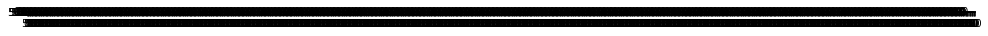

In [29]:
try:
    os.mkdir("./specific")
    os.mkdir("./specific/Remote Sensing Satellite")
except:
    print("directory exists")
    
listspecific = []
for i in range(0,catpd[1].shape[0]):
    try:
        img =cv2.imread("./downloads/Remote Sensing Satellite - thumbnail/"+catpd[1].image_filename[i])
        img = cv2.resize(img, (64,64), cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite("./specific/Remote Sensing Satellite/"+str(i)+".jpg", img)
        listspecific.append(img)
    except:
        print("image not resizable")
        
draw_imgs([listspecific])

In [30]:
specific_generator = test_datagen.flow_from_directory(
        'specific',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')
specific_imgs, specific_labels = next(specific_generator)

Found 692 images belonging to 1 classes.


In [31]:
specific_predictions = cnn.predict_generator(specific_generator, steps=1)

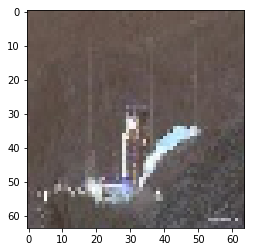

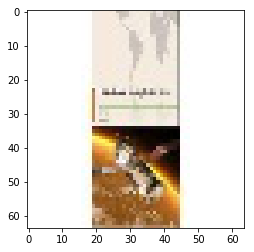

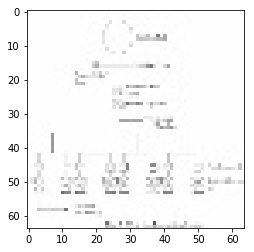

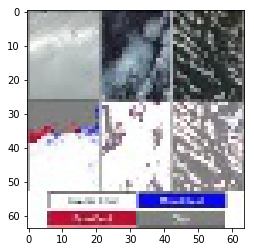

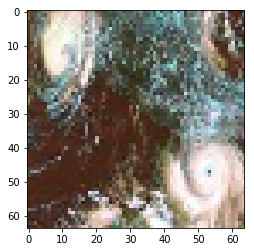

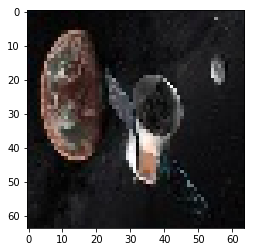

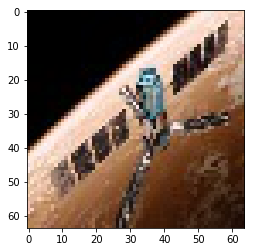

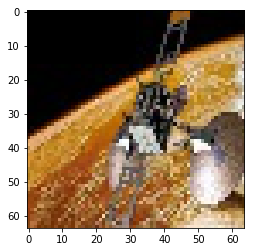

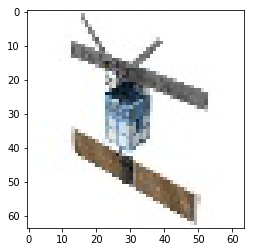

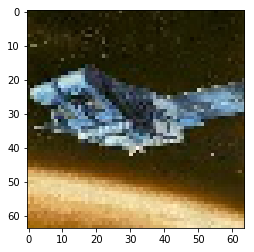

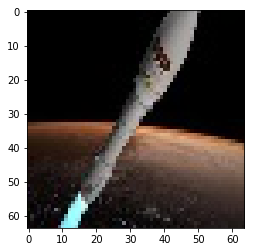

In [32]:
# check satellites
for i in range(0,specific_predictions.shape[0]):
    if specific_predictions[i]>0.5:
        plt.figure()
        plt.imshow(specific_imgs[i])

/home/franck/data/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


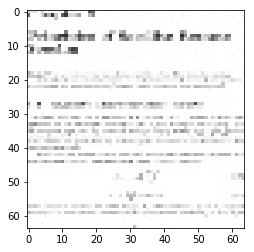

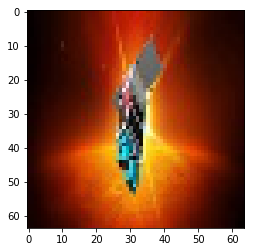

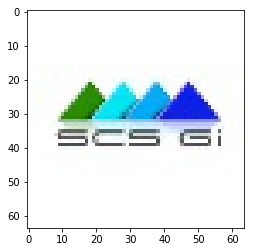

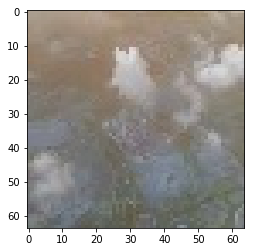

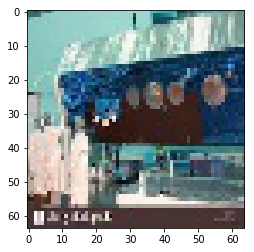

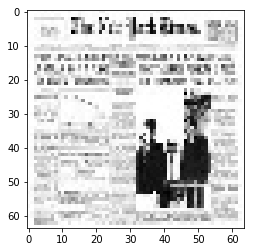

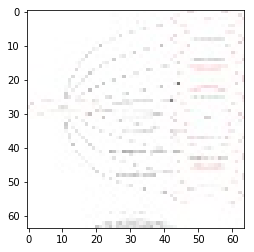

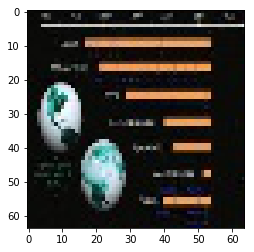

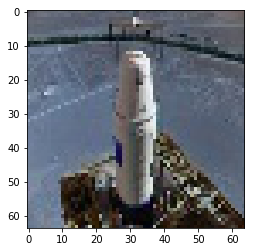

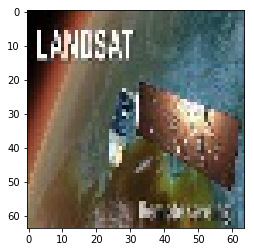

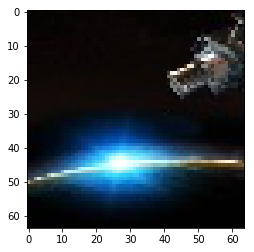

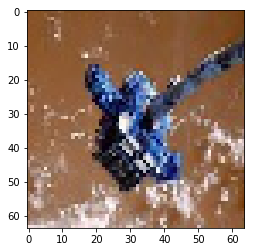

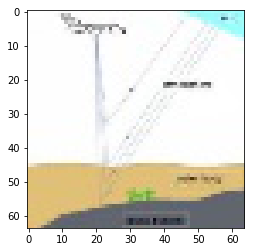

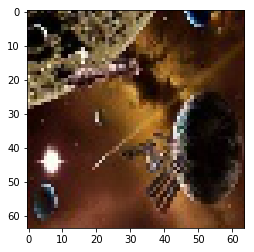

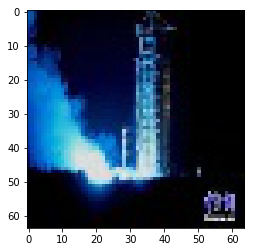

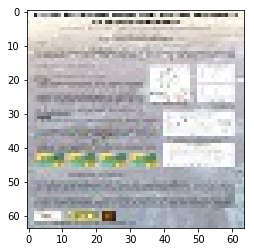

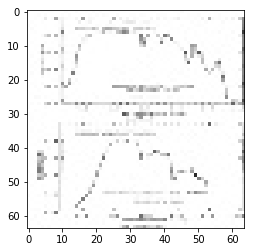

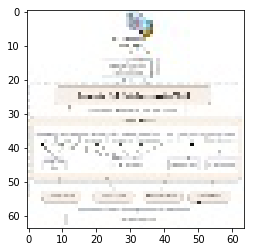

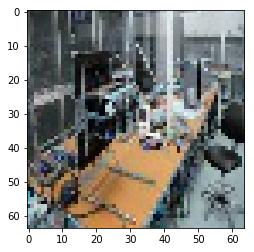

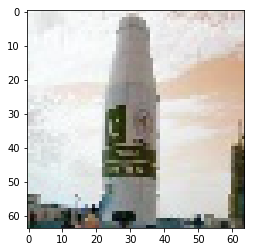

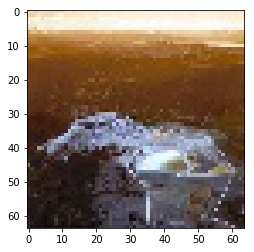

In [33]:
# check non satellites
for i in range(0,specific_predictions.shape[0]):
    if specific_predictions[i]<0.5:
        plt.figure()
        plt.imshow(specific_imgs[i])

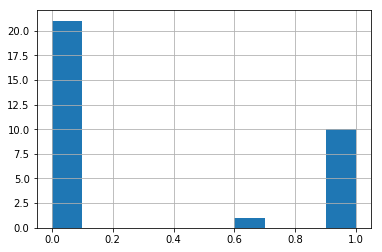

In [34]:
pd.Series(specific_predictions.transpose()[0]).hist()

#### It looks like filtering is not going to work properly so we're just leaving the specific data sets as downloaded

### labelling specific satellite datasets

In [77]:
try:
    os.mkdir("./labelling")
    os.mkdir("./labelling/train")
    os.mkdir("./labelling/test")
    os.mkdir("./labelling/valid")
    for cat in categories:
        os.mkdir("./labelling/train/" + cat)
        os.mkdir("./labelling/test/" + cat)
        os.mkdir("./labelling/valid/" + cat)
except:
    print("directory exists")
    
listlabelling = []
for j in range(0, len(categories)):
    for i in range(0,catpd[j].shape[0]):
        
        try:
            image = "./downloads/"+categories[j]+" - thumbnail/"+catpd[j].image_filename[i]
            dstype = "train"
            if i%3 == 1:
                dstype = "test"
            if i%3 == 2:
                dstype = "valid"
            dest = "./labelling/"+dstype+"/"+categories[j]+"/"+str(i)+".jpg"  
            
            img =cv2.imread(image)
            img = cv2.resize(img, (244,244), cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(dest, img)
            #copyfile(image, dest)
        except:
            print("image not copied")
        


image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied
image not copied


#### We want to use th VGG16 architexture but with only 13 classes

In [78]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x64x64)
inputlayer = Input(shape=(244,244,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(inputlayer)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(2048, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(13, activation='softmax', name='predictions')(x)

#Create the model 
labelmodel = Model(input=inputlayer, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
labelmodel.summary()

/home/franck/data/anaconda3/lib/python3.6/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/home/franck/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=flatten/fl..., outputs=Softmax.0)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 244, 244, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              51382272  
_________________________________________________________________
fc2 (Dense)                  (None, 512)               1049088   
_________________________________________________________________
predictions (Dense)          (None, 13)                6669      
Total params: 67,152,717
Trainable params: 67,152,717
Non-trainable params: 0
________________________________________________________________

In [84]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
labelmodel.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#labelmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
train_label_generator = train_datagen.flow_from_directory(
        'labelling/train',
        target_size=(244, 244),
        batch_size=32,
        class_mode='categorical')

validation_label_generator = test_datagen.flow_from_directory(
        'labelling/valid',
        target_size=(244, 244),
        batch_size=32,
        class_mode='categorical')

Found 2606 images belonging to 13 classes.
Found 2594 images belonging to 13 classes.


In [88]:
labelmodel.fit_generator(
        train_label_generator,
        steps_per_epoch=10,
        epochs=5,
        validation_data=validation_label_generator,
        validation_steps=5)

Epoch 1/5
10/10 [==============================] - 682s 68s/step - loss: 14.4559 - acc: 0.1031 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/5
10/10 [==============================] - 688s 69s/step - loss: 14.6070 - acc: 0.0938 - val_loss: 14.7078 - val_acc: 0.0875
Epoch 3/5
10/10 [==============================] - 666s 67s/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.8085 - val_acc: 0.0813
Epoch 4/5
10/10 [==============================] - 663s 66s/step - loss: 14.7078 - acc: 0.0875 - val_loss: 15.1107 - val_acc: 0.0625
Epoch 5/5
10/10 [==============================] - 665s 66s/step - loss: 14.6574 - acc: 0.0906 - val_loss: 14.1033 - val_acc: 0.1250


#### By looking at the evolution of the accuracy (and validation accuracy) the network is not learning properly
#### some overfitting occurs.
#### We need to improve the quality and quantity of images in the datasets of the different categories to be able 
#### to get a better annotation model.